# **<center>Introduction</center>**

#### _This notebook prepares your environment for subsequent downloads and analysis. When set with the correct variables for your local system, running this notebook will create a script that loads shared packages and variables when imported into subsequent notebooks._

### **<center>Assignment background</center>**

---

This series of notebooks is an analysis and data visualization for the class "Python for Everybody" taught by Dr. Charles Severence (AKA "Dr. Chuck") at the University of Michigan, presented on Coursera. The assignment was to select an open dataset and do some sort of basic analysis and visualization in order to show that we have mastered the basic concepts taught in the course, such as web scraping, data cleaning, databases, and generation of plots.

From the provided list of open data sources, I went to [data.gov](https://data.gov/) and searched for datasets pertaining to New York City, my hometown. That led me to **[NYC OpenData](https://opendata.cityofnewyork.us/)**, where I got the datasets used here. After browsing the available datasets, I decided to go with real estate, as there are several large datasets pertaining to that topic that caught my eye, and I picked these for my analysis.

My hope is that I will design this analysis in a generic enough way that I can use large parts of its code in analyses of other NYC OpenData datasets.


### **<center>Finding and choosing datasets</center>**

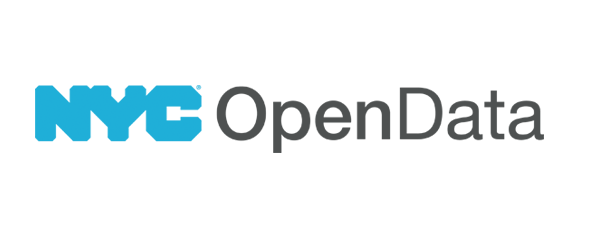

- ### [NYC Open Data Search page](https://data.cityofnewyork.us/browse?q=&sortBy=relevance)

  - [New York City Open Data](https://opendata.cityofnewyork.us/) is a repository of free public data published by New York City agencies and their partners. It is managed by the Open Data Team at the NYC Office of Technology and Innovation (OTI)

- ### Search terms:

  - "property", "housing", "easements", "land use"

- ### Selection of datasets:

  - I did not use any formal criteria to choose datasets, but I favored ones that were larger and included dollar amounts of money as at least one of their fields.

- ### Interesting datasets:
  - These datasets are all related to land use and housing and are cross-referenceable using borough, block, and lot. Although my analysis will only focus on one or two of the datasets, I want to bring together the related data for possible future analysis.
    - **Primary Land Use Tax Lot Output (PLUTO)**: Land use and geographic data at the tax lot level, includes assessed property values. [Dataset main page is here](https://data.cityofnewyork.us/City-Government/Primary-Land-Use-Tax-Lot-Output-PLUTO-/64uk-42ks/about_data).
    - **Property Valuation and Assessment Data**: The Department of Finance-assessed values for properties, evaluated every year as one step in calculating property tax bills. [Dataset main page is here](https://data.cityofnewyork.us/City-Government/Property-Valuation-and-Assessment-Data/yjxr-fw8i/about_data)
    - **Tax Lien Sale Lists**: Properties with tax, water liens and other charges that may be eligible for inclusion in the next lien sale, as well as tax liens which were eventually sold. [Dataset main page is here](https://data.cityofnewyork.us/City-Government/Tax-Lien-Sale-Lists/9rz4-mjek/about_data)
    - **Housing Maintenance Code Violations**: Violations against conditions, in rental dwelling units and buildings, that have been verified to violate the New York City Housing Maintenance Code (HMC) or the New York State Multiple Dwelling Law (MDL). [Dataset main page is here](https://data.cityofnewyork.us/Housing-Development/Housing-Maintenance-Code-Violations/wvxf-dwi5/about_data)
    - **Assessment Actions**: Tax Commission actions for reducing assessments or reclassifying property. [Dataset main page is here](https://data.cityofnewyork.us/City-Government/Assessment-Actions/4nft-bihw/about_data)
    - **Housing Database**: NYC Department of City Planning (DCP) Housing Database containing all NYC Department of Buildings (DOB)-approved housing construction and demolition jobs filed or completed in NYC since January 1, 2010. [Dataset main page is here](https://data.cityofnewyork.us/Housing-Development/Housing-Database/6umk-irkx/about_data). The dataset itself is hosted elsewhere, so the url creation strategy that I use for the other datasets will not work.

#### _For the selected datasets, the id should be the only thing needed to construct urls and set up the necessary variables. The id is in the url for the dataset main page between the name of the dataset and '/about_data', shown in bold: [https://data.cityofnewyork.us/City-Government/Primary-Land-Use-Tax-Lot-Output-PLUTO-/**64uk-42ks**/about_data](https://data.cityofnewyork.us/City-Government/Primary-Land-Use-Tax-Lot-Output-PLUTO-/64uk-42ks/about_data)_

---


# **<center>Environment setup</center>**

---

- ### Import the libraries used in this notebook


In [ ]:
import os
import time
from dataclasses import dataclass, field
from typing import List
import re
import requests
from sqlalchemy import Integer, Float, String, Date, LargeBinary, Boolean
import dill
from src.helpers import *
from src.models import *


- ### Customize the directories to be used to where on your machine you want them.
  - #### Set paths for where to create the data folder where datasets will be downloaded and the sqlite database created. It will be at least several gigabytes if not more, so make sure you have space.


In [2]:
# Directory where the data folder for this analysis is to be created
DATADIR = "/home/james/Massive/PROJECTDATA"

# Name of the folder in which the project data is stored
PROJECT_NAME = "nyc_real_estate"

- ### Set the names and paths of the datasets to be used. Here they are already set for the analysis I am doing, but the hope is to make it as adaptable to other datasets as possible.


In [3]:
# Create paths that will be frequently used throughout the project
PROJECT_PATH = os.getcwd()
PROJECT_DATA = f"{DATADIR}/{PROJECT_NAME}_data"
SQLITE_PATH = f"sqlite:///{PROJECT_DATA}/{PROJECT_NAME}_db.sqlite"

In [4]:

# Create necessary directories from the paths
os.makedirs(
    PROJECT_DATA, exist_ok=True
)  # Make the main directory for the project downloads and data
os.makedirs(f"{PROJECT_DATA}/downloads", exist_ok=True)  # Make the download directory
os.makedirs(
    f"{PROJECT_DATA}/intermediate_files", exist_ok=True
)  # Location for intermediate files
os.makedirs(
    f"{PROJECT_DATA}/files_to_use", exist_ok=True
)  # Location where cleaned data to be directly used in analysis is stored
os.makedirs(
    f"{PROJECT_DATA}/dictionaries", exist_ok=True
)  # Location where cleaned data to be directly used in analysis is stored

- ### Create a dataclass to store metadata about the datasets.


In [5]:
# Dataclass to hold information about an NYC Open Data dataset, to filled with metadata provided by the API
@dataclass
class Dataset:
    """Class to hold dataset metadata"""

    main_url: str  # The url for the dataset's main page
    standard: bool = (
        True  # Set to False if either the dataset is not hosted on NYC Open Data or follows a format different from the standard
    )
    geodata: bool = False
    id: str = field(
        init=False
    )  # the string ID used by NYC Open Data. In most cases, this is enough to construct all needed URLs.
    metadata_url: str = field(init=False)  # The download URL for the dataset
    data_url: str = field(default=None)  # The download URL for the dataset
    format: str = field(default="json")  # File format of the data_url
    data_dict_url: str = None  # The URL for the dataset's data dictionary
    other_files: List[str] = None  # A list of other files associated with the dataset
    name: str = None  # The name of the dataset
    short_name: str = None  # My shortened name for the dataset
    attribution: str = (
        None  # The attribution for the dataset according to NYC Open Data
    )
    createdAt: str = None  # The date the dataset was created by NYC Open Data
    description: str = None  # NYC Open Data's description of the dataset
    provenance: str = None  # NYC Open Data's provenance for the dataset
    publicationDate: str = None  # Publication date of the dataset
    rowsUpdatedAt: str = (
        None  # The date the dataset was last updated at the time of metadata retrieval
    )
    columns: dict = field(
        default_factory=dict
    )  # A dictionary of the columns in the dataset and their data types

    def __post_init__(self):
        self.id = re.sub(
            r".*/(.*)/about_data", r"\1", self.main_url
        )  # Extract the ID from the main URL
        self.metadata_url = f"https://data.cityofnewyork.us/api/views/{self.id}.json"
        if self.data_url is None:  # Only construct the `data_url` if it's not provided
            self.data_url = (
                f"https://data.cityofnewyork.us/api/views/{self.id}/rows.json?accessType=DOWNLOAD"
                if self.standard
                else None
            )

- ### Create instances of the new dataclass for each dataset.

  - #### Create a dictionary of instances of the `Dataset` dataclass, one for each dataset I have chosen The keys are a shortened version of the dataset name that I made up. Values are the urls for the information pages that one finds when [searching the OpenData website](https://data.cityofnewyork.us/browse?q=&sortBy=relevance). Although it would take a lot of testing to verify, the intention is to be able to substitute a different set of urls and proceed through the notebook set with minimal modification. I opted not to use it this time, but if the code proves to be reusable, I could use a tool like [Papermill](https://papermill.readthedocs.io/en/latest/)


In [6]:
datasets = {
    "mapPLUTO": Dataset(
        main_url="https://data.cityofnewyork.us/City-Government/Primary-Land-Use-Tax-Lot-Output-Map-MapPLUTO-/f888-ni5f/about_data",
        standard=False,
        data_url="https://s-media.nyc.gov/agencies/dcp/assets/files/zip/data-tools/bytes/nyc_mappluto_24v4_fgdb.zip",
        format="zip",
        geodata=True,
    ),
    "assessments": Dataset(
        main_url="https://data.cityofnewyork.us/City-Government/Property-Valuation-and-Assessment-Data/yjxr-fw8i/about_data"
    ),
    "tax_liens": Dataset(
        main_url="https://data.cityofnewyork.us/City-Government/Tax-Lien-Sale-Lists/9rz4-mjek/about_data"
    ),
    "housing_violations": Dataset(
        main_url="https://data.cityofnewyork.us/Housing-Development/Housing-Maintenance-Code-Violations/wvxf-dwi5/about_data"
    ),
    "assessment_actions": Dataset(
        main_url="https://data.cityofnewyork.us/City-Government/Assessment-Actions/4nft-bihw/about_data"
    ),
    "housing_database": Dataset(
        main_url="https://data.cityofnewyork.us/Housing-Development/Housing-Database/6umk-irkx/about_data",
        standard=False,
        data_url="https://s-media.nyc.gov/agencies/dcp/assets/files/zip/data-tools/bytes/nychousingdb_24q2_gdb.zip",
        format="zip",
        geodata=True,
    ),
    "NTAs2020": Dataset(
        main_url="https://data.cityofnewyork.us/City-Government/2020-Neighborhood-Tabulation-Areas-NTAs-/9nt8-h7nd/about_data"
    ),
    "NTA_population_2020": Dataset(
        main_url="https://data.cityofnewyork.us/City-Government/New-York-City-Population-By-Neighborhood-Tabulatio/swpk-hqdp/about_data"
    ),
    "NTA_demographics_2020": Dataset(
        main_url="https://data.cityofnewyork.us/City-Government/Census-Demographics-at-the-Neighborhood-Tabulation/rnsn-acs2/about_data"
    ),
    "census_blocks2020": Dataset(
        main_url="https://data.cityofnewyork.us/City-Government/2020-Census-Blocks/wmsu-5muw/about_data"
    ),
    "CDTAs2020": Dataset(
        main_url="https://data.cityofnewyork.us/City-Government/2020-Community-District-Tabulation-Areas-CDTAs-/xn3r-zk6y/about_data"
    ),
    "puma2020": Dataset(
        main_url="https://data.cityofnewyork.us/City-Government/2020-Public-Use-Microdata-Areas-PUMAs-/pikk-p9nv/about_data"
    ),
    "cert_of_occupancy": Dataset(
        main_url="https://data.cityofnewyork.us/Housing-Development/DOB-Certificate-Of-Occupancy/bs8b-p36w/about_data"
    ),
}

In [ ]:
for name, dataset in datasets.items():
    print(name, dataset.data_url)

- ### Inspect the metadata for the chosen datasets to identify columns to rename, specify the data type of, or make other decisions about.


In [7]:
for short_name, dataset in datasets.items():
    print(short_name)
    response = requests.get(dataset.metadata_url, timeout=10)
    response.raise_for_status()
    metadata = response.json()
    data_dict = [
        (attachment["assetId"], attachment["filename"])
        for attachment in metadata["metadata"]["attachments"]
        if any(s in attachment["filename"].casefold() for s in ["dict", "dd"])
    ]
    if data_dict:
        dataset.data_dict_url = f"https://data.cityofnewyork.us/api/views/{dataset.id}/files/{data_dict[0][0]}?download=true&filename={data_dict[0][1]}"
    dataset.name = metadata["name"]
    dataset.short_name = short_name
    try:
        dataset.other_files = [
            (attachment["assetId"], attachment["filename"])
            for attachment in metadata["metadata"]["attachments"]
            if not any(s in attachment["filename"].casefold() for s in ["dict", "dd"])
        ]
    except KeyError:
        dataset.other_files = None
    try:
        dataset.attribution = metadata["attribution"]
    except KeyError:
        dataset.attribution = None
    try:
        dataset.createdAt = metadata["createdAt"]
    except KeyError:
        dataset.attribution = None
    try:
        dataset.description = metadata["description"]
    except KeyError:
        dataset.attribution = None
    try:
        dataset.provenance = metadata["provenance"]
    except KeyError:
        dataset.attribution = None
    try:
        dataset.publicationDate = metadata["publicationDate"]
    except KeyError:
        dataset.attribution = None
    try:
        dataset.rowsUpdatedAt = (
            (  # The column for when the dataset was last updated is usually called `rowsUpdatedAt`, but sometimes it's called `viewLastModified`
                metadata["rowsUpdatedAt"]
                if "rowsUpdatedAt" in metadata.keys()
                else (
                    metadata["viewLastModified"]
                    if "viewLastModified" in metadata.keys()
                    else None
                )
            ),
        )
    except KeyError:
        dataset.attribution = None
    try:
        dataset.columns = {
            col["name"]: col["dataTypeName"] for col in metadata["columns"]
        }
    except KeyError:
        dataset.attribution = None
    time.sleep(5)

mapPLUTO
assessments
tax_liens
housing_violations
assessment_actions
housing_database
NTAs2020
NTA_population_2020
NTA_demographics_2020
census_blocks2020
CDTAs2020
puma2020
cert_of_occupancy


In [ ]:
for name, dataset in datasets.items():
    print(name, dataset.data_dict_url)

In [11]:
# objects_to_save = [datasets, PROJECT_PATH, PROJECT_DATA, SQLITE_PATH, DATADIR, PROJECT_NAME]

objects_to_save = {'datasets' : datasets, 'PROJECT_PATH' : PROJECT_PATH, 'PROJECT_DATA' : PROJECT_DATA, 'SQLITE_PATH' : SQLITE_PATH, 'DATADIR' : DATADIR, 'PROJECT_NAME' : PROJECT_NAME}

with open("environment_data/select.pkl", "wb") as f:
    dill.dump(objects_to_save, f)

In [9]:
# Create a copy of the globals() dictionary to avoid RuntimeError
globals_copy = globals().copy()

# List of known problematic objects
exclude_keys = ["get_ipython", "exit", "quit"]

# Filter out non-serializable objects and log warnings
serializable_globals = {}
for k, v in globals_copy.items():
    if k not in exclude_keys:
        try:
            dill.dumps(v)
            serializable_globals[k] = v
        except Exception as e:
            print(f"Warning: Could not serialize object {k}: {e}")

# Save the filtered environment
os.makedirs(
    f"environment_data", exist_ok=True
)  # Directory to store environment files, excluded in .gitignore
with open("environment_data/environment.pkl", "wb") as f:
    dill.dump(serializable_globals, f)

In [ ]:
for name, dataset in datasets.items():
    print(name)
    print(dataset.data_url)
    downloader(
        url=dataset.data_url,
        download_path=f"{PROJECT_DATA}/downloads",
        outfile_name=f"{dataset.short_name}.{dataset.format}",
        bigfile=True,
        chunk_size=8192,
    )
    if dataset.data_dict_url is not None:
        try:
            file_type = dataset.data_dict_url.split(".")[-1]
        except AttributeError:
            print(
                f"{RED}Could not parse filetype from {CYAN}{dataset.data_dict_url}{RESET}!"
            )
            continue
        print(dataset.data_dict_url)
        downloader(
            url=dataset.data_dict_url,
            download_path=f"{PROJECT_DATA}/dictionaries/",
            outfile_name=f"{dataset.short_name}_data_dictionary.{file_type}",
            bigfile=False,
        )

In [ ]:
for name, dataset in datasets.items():
    print(name)
    print(dataset.data_url)
    if dataset.format == "json":
        jqfilter(
            infile=f"{PROJECT_DATA}/downloads/{name}.json",
            outfile=f"{PROJECT_DATA}/files_to_use/{name}_rows.json",
            jq_filter=".data",
        )
    elif dataset.format == "zip":
        unzipper(
            infile=f"{PROJECT_DATA}/downloads/{name}.zip",
            outdir=f"{PROJECT_DATA}/files_to_use/",
        )
    print(f"Done with {dataset.data_url}")

In [ ]:
for name, dataset in datasets.items():
    print(name)
    print(dataset.columns)